# Task
Пробую поиск гиперпараметров по сетке

Задача: Поднять значение метрики Precision

# Import modules

In [52]:
# для автозагрузки изменений в модулях без необходимости перезагрузки kelner
%load_ext autoreload
%autoreload 2

# необходимо для корректного импорта своих модулей в JupyterLab
import sys
current_dir = sys.path[0]
project_dir = 'SF_DS_Pro'
last_position = current_dir.find(project_dir) + len(project_dir)
project_path = current_dir[:last_position]
sys.path.append(project_path)

import Handlers as hd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

from sklearn.model_selection import train_test_split # сплитование выборки
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from category_encoders import OneHotEncoder, BinaryEncoder
from sklearn import model_selection

from statsmodels.tsa.stattools import adfuller

import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

from sklearn import set_config
set_config(transform_output='pandas')

%matplotlib inline
plt.style.use('seaborn-darkgrid')
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (10, 8)

# Load Data

In [54]:
data = pd.read_parquet('..\ETH-Full-1H.parquet')

In [55]:
df = data.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49337 entries, 2017-09-01 00:00:00 to 2023-04-23 23:00:00
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    49337 non-null  float64
 1   High    49337 non-null  float64
 2   Low     49337 non-null  float64
 3   Close   49337 non-null  float64
 4   Volume  49337 non-null  float64
 5   Trades  49337 non-null  int32  
dtypes: float64(5), int32(1)
memory usage: 2.4 MB


In [56]:
df

,Open,High,Low,Close,Volume,Trades
Datetime,,,,,,
2017-09-01 00:00:00,384.79,388.74,384.79,388.74,162.97779,131
2017-09-01 01:00:00,388.69,394.06,387.53,391.37,248.72949,262
2017-09-01 02:00:00,392.88,394.39,389.46,390.88,198.82856,225
2017-09-01 03:00:00,391.70,393.13,390.86,390.86,141.56114,138
2017-09-01 04:00:00,392.65,394.27,387.64,390.33,135.65894,128
...,...,...,...,...,...,...
2023-04-23 19:00:00,1846.76,1852.35,1844.92,1846.49,16550.18290,21648
2023-04-23 20:00:00,1846.49,1852.30,1838.03,1848.89,13113.47550,19445
2023-04-23 21:00:00,1848.88,1859.32,1847.59,1854.66,7855.61330,13824


# Base Visualization

In [57]:
# # If need to plot not all data
# # df_to_plot = df[df.index >= '2018-01-01']
# df_to_plot = df

# # Create a 2-row, 1-column subplot grid
# fig, ax = plt.subplots(3, 1, figsize=(16, 10), sharex=True)

# # Convert series to numpy
# ind = df_to_plot.index.to_numpy()
# _0 = df_to_plot['Close'].to_numpy()
# _1 = df_to_plot['Volume'].to_numpy()
# _2 = df_to_plot['Trades'].to_numpy()

# ax[0].plot(ind, _0, linewidth=1)
# ax[0].set_title('Close')

# ax[1].fill_between(ind, _1, step='pre')
# ax[1].set_title('Volume')

# ax[2].fill_between(ind, _2, step='pre')
# ax[2].set_title('Trades')

# # Set the x-axis label for the entire figure
# plt.xlabel('Date')

# # Adjust the layout and show the plot
# plt.tight_layout()
# plt.show()

В 17 году совсем маленькие объемы, подрежу данные. Не буду брать то что до 18 года

In [58]:
df = df[df.index >= '2018-01-01'].copy()

### Провека всех признаков исходного ряда на стационарность

In [59]:
# for col_name, col_data in df.items():
#     print("Column Name : ", col_name)
#     hd.adf(col_data.values)
#     print()

Volume, Trades стационарны и то, значения пограничные. Надо преобразовывать.

# Feature Enginiring
Логарифмирую все признаки

In [60]:
cols = df.columns
for col in cols:
    df[col + '_log'] = np.log(df[col])

# df.drop(columns=cols, inplace=True) # удаляю все старые признаки

In [61]:
df

,Open,High,Low,Close,Volume,Trades,Open_log,High_log,Low_log,Close_log,Volume_log,Trades_log
Datetime,,,,,,,,,,,,
2018-01-01 00:00:00,733.01,734.52,720.03,727.62,2105.90100,3114,6.597159,6.599217,6.579293,6.589779,7.652499,8.043663
2018-01-01 01:00:00,727.01,732.00,716.80,717.97,2305.97086,2875,6.588940,6.595781,6.574797,6.576428,7.743257,7.963808
2018-01-01 02:00:00,717.67,725.75,717.59,724.05,2166.45725,2957,6.576010,6.587206,6.575898,6.584860,7.680849,7.991931
2018-01-01 03:00:00,723.95,737.99,722.70,734.50,2160.90450,3647,6.584722,6.603930,6.582994,6.599190,7.678282,8.201660
2018-01-01 04:00:00,734.99,744.98,730.01,744.82,2335.33705,3512,6.599857,6.613357,6.593058,6.613143,7.755912,8.163941
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-23 19:00:00,1846.76,1852.35,1844.92,1846.49,16550.18290,21648,7.521188,7.524210,7.520191,7.521042,9.714152,9.982668
2023-04-23 20:00:00,1846.49,1852.30,1838.03,1848.89,13113.47550,19445,7.521042,7.524183,7.516450,7.522341,9.481396,9.875345
2023-04-23 21:00:00,1848.88,1859.32,1847.59,1854.66,7855.61330,13824,7.522335,7.527966,7.521637,7.525457,8.968984,9.534161


Тени от открытия бара на лог шкале

In [62]:
df['Low_Shad_log'] = df['Open_log'] - df['Low_log']
df['High_Shad_log'] = df['High_log'] - df['Open_log']

Прирост за бар на лог шкале

Фактически это аналог first log difference

Прирост и тени от открытия бара, т.к. в истории есть пропуски по много часов и они могут давать сильные искажения, вылеты для таргетов

In [63]:
df['Log_Return'] = df['Close_log'] - df['Open_log']

Диапазон бара логарифмический

In [64]:
df['Log_Range'] = df['High_log'] - df['Low_log']
df['Range_diff'] = df['Log_Range'].diff()

Прирост объема и количества сделок

In [65]:
df['Diff_Vol_log'] = df['Volume_log'].diff()
df['Diff_Trade_log'] = df['Volume_log'].diff()

Доля которую занимате тело свечи в % от всего размаха

In [66]:
df['Body_share'] = df['Log_Return'].abs() / df['Log_Range'] * 100

Средний трейд и первая разница среднего трейда

In [67]:
df['Avg_Trade'] = df['Volume'] / df['Trades']
df['Diff_Avg_Trade'] = df['Avg_Trade'].diff()

In [68]:
df.dropna(inplace=True)

In [69]:
# for col_name, col_data in df.items():
#     print('Column Name : ', col_name)
#     hd.adf(col_data.values)
#     print()

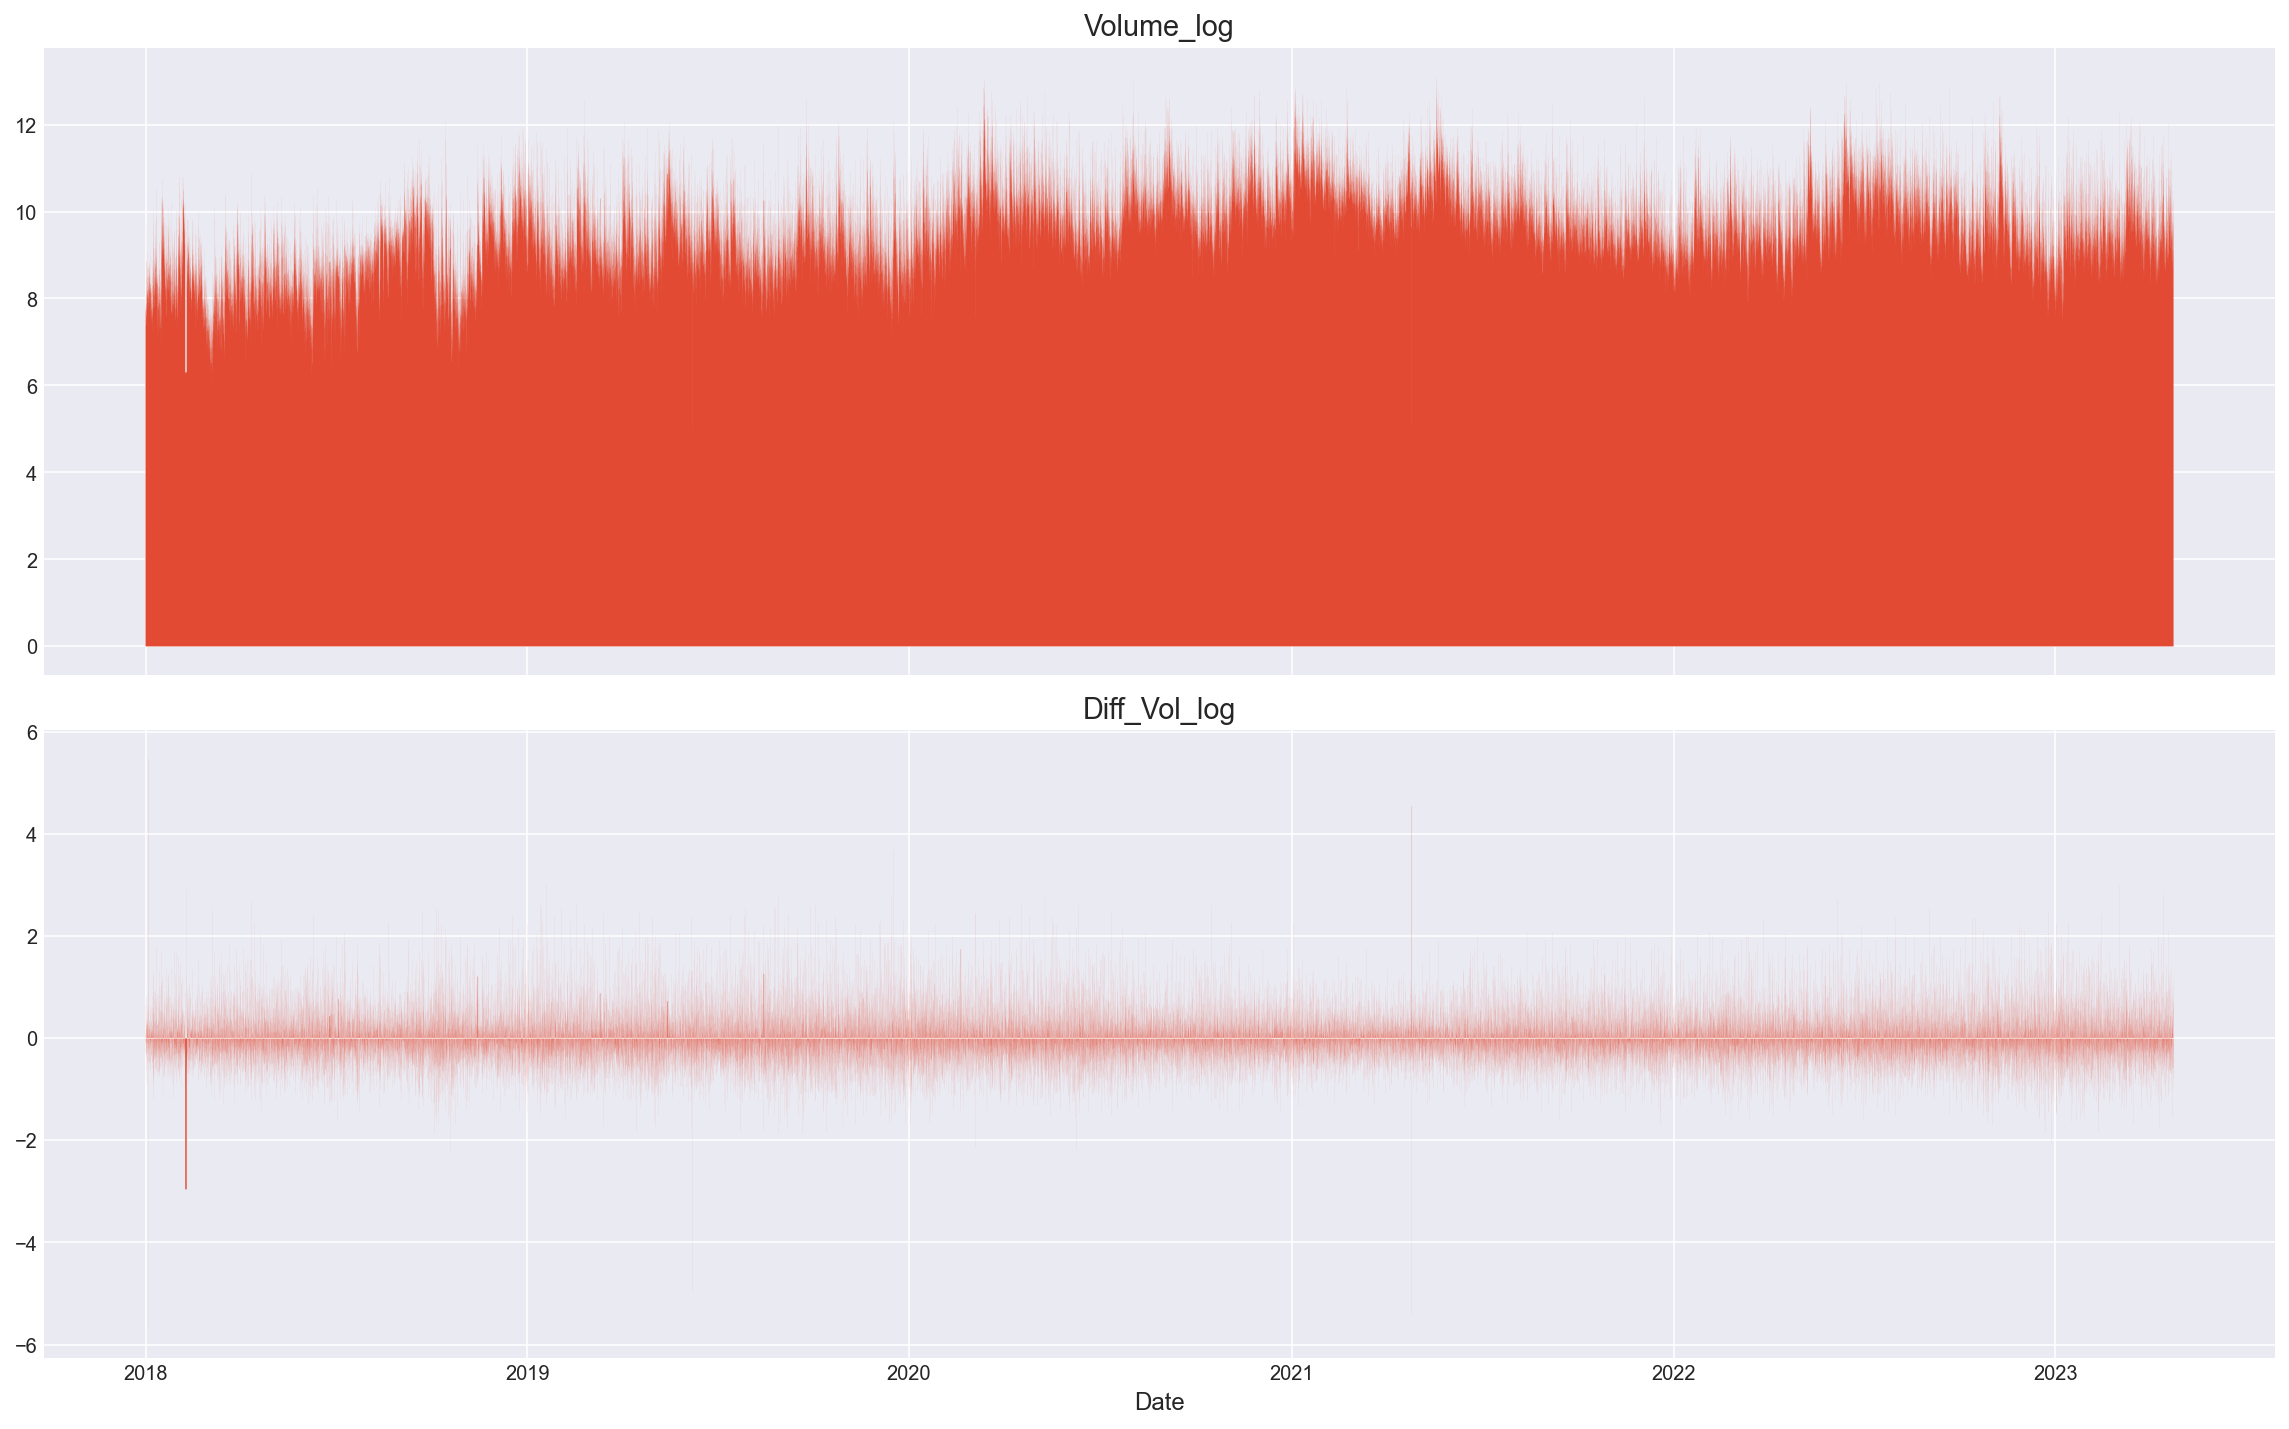

In [70]:
# If need to plot not all data
# df_to_plot = df[df.index >= '2018-01-01']
df_to_plot = df

# Create a 2-row, 1-column subplot grid
fig, ax = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

# Convert series to numpy
ind = df_to_plot.index.to_numpy()
_0 = df_to_plot['Volume_log'].to_numpy()
_1 = df_to_plot['Diff_Vol_log'].to_numpy()

ax[0].fill_between(ind, _0, step='pre')
ax[0].set_title('Volume_log')

ax[1].fill_between(ind, _1, step='pre')
ax[1].set_title('Diff_Vol_log')

# Set the x-axis label for the entire figure
plt.xlabel('Date')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

In [71]:
def add_datetime_features(df, as_category=True):
    """Функция для генерации признаков даты/времени из индекса датафрейма

    Args:
        df (_type_): исходный датафрейм
        as_category (bool, optional): Кодидровать ли созданные признаки. Defaults to True.

    Returns:
        _type_: возвращает новый датафрейм
    """
    
    new_df = df.copy()
    
    date_time = new_df.index
    new_df['M'] = date_time.month # Month
    new_df['W'] = date_time.isocalendar().week # Week from year begin
    new_df['MD'] = date_time.day # Day of Month
    new_df['WD'] = date_time.weekday # Day of Week
    new_df['H'] = date_time.hour # Hour
    
    if as_category:
        new_df['M'] = new_df['M'].astype('category')
        new_df['W'] = new_df['W'].astype('category')
        new_df['MD'] = new_df['MD'].astype('category')
        new_df['WD'] = new_df['WD'].astype('category')
        new_df['H'] = new_df['H'].astype('category')
        
    return new_df

In [72]:
df = add_datetime_features(df, as_category=True)

# Create Target Category Feature 
Создаю целевой признак

Это фактически очередные гиперпараметры.

Я могу задавать уровень риска в лог величинах - risk_level

и коэффициент доходность/риск в виде множителя - risk_factor

Т.е. текущий случай это:
* risk_level = 0.0025
* risk_factor = 4

In [73]:
risk_level = 0.0025
profit_factor = 4
profit_level = risk_level * profit_factor
TARGET = 'Long'

In [74]:
zero_mo = hd.profit_margin_for_zero_mo(risk_level, profit_factor)
print('Метрика Precision должна быть выше:', zero_mo)

Метрика Precision должна быть выше: 0.2


In [75]:
df[TARGET] = np.where((df['High_Shad_log'] >= profit_level) & (df['Low_Shad_log'] <= risk_level), 1, 0)

Анализ распределения классов целевого признака

In [76]:
class_df = pd.DataFrame({'%': (df[TARGET].value_counts(True) * 100).round(2), 'Count': df[TARGET].value_counts()})
class_df.index.name = 'Class'
class_df.sort_index(ascending=False, inplace=True)
class_df

,%,Count
Class,,
1,9.16,4252
0,90.84,42159


# Feature Engineering
* Преобразую исходные данные
* Получаю новые признаки. 
* Удаляю ненужные.
* Обогощаю данные.

* Объемы и сделки:
Можно считать средний объем сделки. 
- AvrTrade = Volume / Trades
- Объем в долларах, т.е. нормированный объем VolUSD = Volume * Close
- Объем на единицу диапазона.

### Определяю признаки

In [77]:
# df_new = df[['Log_Return', 'High_Shad_log', 'Low_Shad_log', 'Diff_Vol_log', TARGET]].copy()
df_new = df[['Log_Return', 'High_Shad_log', 'Low_Shad_log', 'Log_Range', 'Body_share', TARGET]].copy()
df_new

,Log_Return,High_Shad_log,Low_Shad_log,Log_Range,Body_share,Long
Datetime,,,,,,
2018-01-01 01:00:00,-0.012512,0.006840,0.014143,0.020984,59.629501,0
2018-01-01 02:00:00,0.008851,0.011196,0.000111,0.011307,78.273806,1
2018-01-01 03:00:00,0.014468,0.019208,0.001728,0.020936,69.104002,1
2018-01-01 04:00:00,0.013286,0.013500,0.006799,0.020299,65.449497,0
2018-01-01 05:00:00,0.005637,0.006984,0.003632,0.010616,53.096068,0
...,...,...,...,...,...,...
2023-04-23 19:00:00,-0.000146,0.003022,0.000997,0.004019,3.637867,0
2023-04-23 20:00:00,0.001299,0.003142,0.004592,0.007734,16.795435,0
2023-04-23 21:00:00,0.003121,0.005631,0.000698,0.006329,49.320075,0


# Временные признаки, которым не нужна глубина

In [78]:
df_time = df[['H', 'WD', TARGET]].copy()

Кодирование категориальных признаков

In [79]:
ohe = OneHotEncoder(cols=['H', 'WD'])
df_time = ohe.fit_transform(df_time)

In [80]:
df_time

,H_1,H_2,H_3,H_4,H_5,H_6,H_7,H_8,H_9,H_10,...,H_23,H_24,WD_1,WD_2,WD_3,WD_4,WD_5,WD_6,WD_7,Long
Datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-01 01:00:00,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2018-01-01 02:00:00,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2018-01-01 03:00:00,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2018-01-01 04:00:00,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2018-01-01 05:00:00,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-23 19:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2023-04-23 20:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2023-04-23 21:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


# Transform TimeSeries to Dataset for Supervised Learning
Тут определяется глубина последовательности данных T, которая будет использоваться для построения прогноза. Временное окно в прошлое.

Т это так же гиперпараметр, его так же нужно будет искать по сетке.

In [81]:
T = 24 # len of sequence. Num of time steps to look at to make prediction on next step

Create $X$, $y$

In [82]:
X, y, N, D = hd.create_X_y_from_timeseries(df_new, TARGET, T)

In [83]:
print('X.shape:', X.shape, 'y.shape:', y.shape, 'N:', N, 'D:', D)

X.shape: (46387, 120) y.shape: (46387,) N: 46387 D: 5


Преобразование временных признаков, где не нужна последовательность, а всего лишь значение на последнем баре

In [84]:
X_t, y_t, _, _ = hd.create_X_y_from_timeseries(df_time, TARGET, 1)

In [85]:
print('X.shape:', X_t.shape, 'y.shape:', y_t.shape)

X.shape: (46410, 31) y.shape: (46410,)


Выправляю длину, объединяю признаки

In [86]:
X_t = X_t[-N:,]
X = np.concatenate((X, X_t), axis=1)
X.shape

(46387, 151)

# Split Data
Разбиение с стратифиацией

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)

# Outliers
Обработка выбросов. Пробовать прорядить выборку удалением записей по методу:
- 3х сигм
- методу Тьюки
- Isolation Forest
- Local Outlier Factor
- Minimun Covariance Determinant

Но обработку надо делать уже после разделения выборки на train/test

# Scaling Data
Нужно скалировать признаки, приводить их к одному масштабу. Путем перебора выбирать лучший скалер.

In [89]:
scaler = StandardScaler()
# scaler = RobustScaler()
# scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create Model

In [90]:
lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

In [91]:
hd.print_classification_metrics(y_train, y_train_pred, y_test, y_test_pred)

*** TRAIN ***
Accuracy: 0.634
Precision: 0.133
Recall: 0.544
F1: 0.214

*** TEST ***
Accuracy: 0.619
Precision: 0.127
Recall: 0.539
F1: 0.206


In [92]:
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

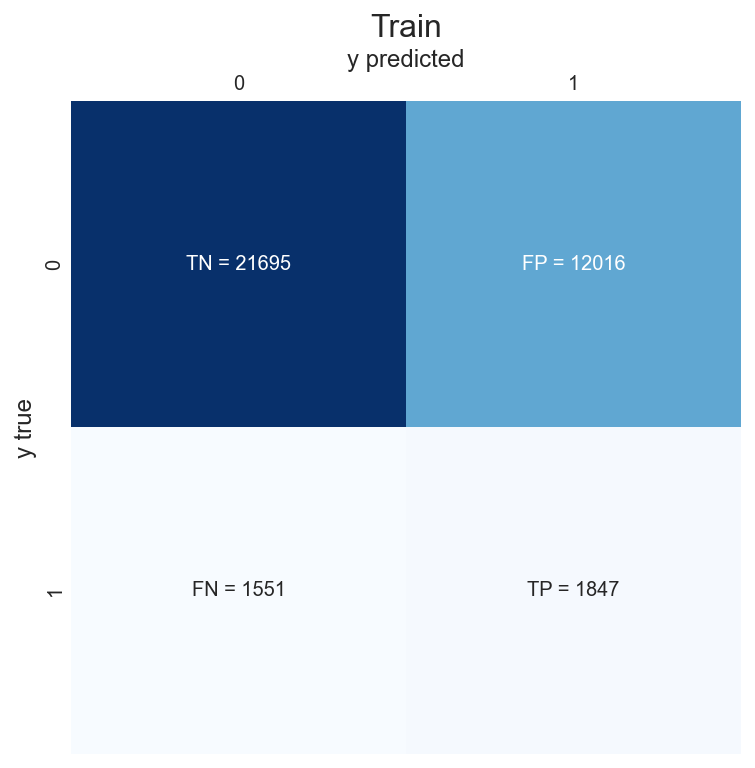

In [93]:
hd.plot_confusion_matrix(cm_train, 'Train')

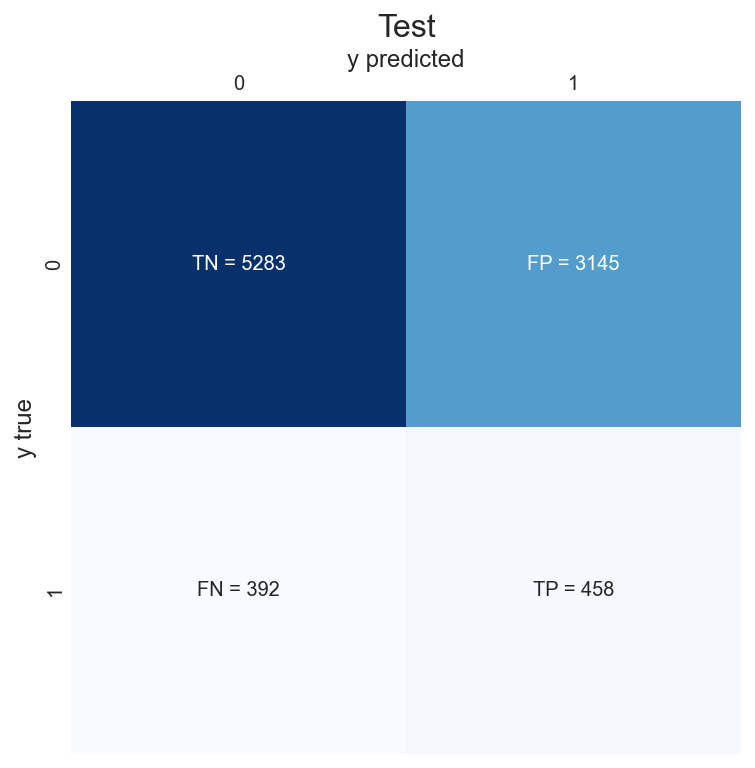

In [94]:
hd.plot_confusion_matrix(cm_test, 'Test')

# GridSearch

In [95]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [97]:
param_grid = [
              {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}, # уровень силы регурялизации
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
]

grid_search = GridSearchCV(
    estimator=LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42), 
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs = -1,
    scoring='f1'
)  

%time grid_search.fit(X_train, y_train)
y_train_pred = grid_search.predict(X_train)
y_test_pred = grid_search.predict(X_test)

print(f'precision_score на train наборе: {precision_score(y_train, y_train_pred):.2f}')
print(f'recall_score на train наборе: {recall_score(y_train, y_train_pred):.2f}')
print(f'f1_score на train наборе: {f1_score(y_train, y_train_pred):.2f}')
print()
print(f'precision_score на test наборе: {precision_score(y_test, y_test_pred):.2f}')
print(f'recall_score на test наборе: {recall_score(y_test, y_test_pred):.2f}')
print(f'f1_score на test наборе: {f1_score(y_test, y_test_pred):.2f}')
print()
print(f'Наилучшие значения гиперпараметров: {grid_search.best_params_}')

CPU times: total: 1.11 s
Wall time: 3min 31s
recision_score на train наборе: 0.14
recall_score на train наборе: 0.55
f1_score на train наборе: 0.22

recision_score на test наборе: 0.13
recall_score на test наборе: 0.54
f1_score на test наборе: 0.21

Наилучшие значения гиперпараметров: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}


In [98]:
print(f'Наилучшая модель:\n{grid_search.best_estimator_}')

Наилучшая модель:
LogisticRegression(C=0.01, class_weight='balanced', max_iter=1000, penalty='l1',
                   random_state=42, solver='liblinear')


In [107]:
param_grid = [
              {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}, # уровень силы регурялизации
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
]

grid_search = GridSearchCV(
    estimator=LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42), 
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs = -1,
    scoring=f1_score
)  

%time grid_search.fit(X_train, y_train)
y_train_pred = grid_search.predict(X_train)
y_test_pred = grid_search.predict(X_test)

print(f'precision_score на train наборе: {precision_score(y_train, y_train_pred):.2f}')
print(f'recall_score на train наборе: {recall_score(y_train, y_train_pred):.2f}')
print(f'f1_score на train наборе: {f1_score(y_train, y_train_pred):.2f}')
print()
print(f'precision_score на test наборе: {precision_score(y_test, y_test_pred):.2f}')
print(f'recall_score на test наборе: {recall_score(y_test, y_test_pred):.2f}')
print(f'f1_score на test наборе: {f1_score(y_test, y_test_pred):.2f}')
print()
print(f'Наилучшие значения гиперпараметров: {grid_search.best_params_}')

c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  warnings.warn(


CPU times: total: 1.61 s
Wall time: 3min 5s
precision_score на train наборе: 0.13
recall_score на train наборе: 0.54
f1_score на train наборе: 0.21

precision_score на test наборе: 0.13
recall_score на test наборе: 0.54
f1_score на test наборе: 0.21

Наилучшие значения гиперпараметров: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}


### Настройка порога вероятности для логистической регрессии после кросс-валидации и поиска параметров по сетке

In [108]:
# Тут берем таблицу вероятностей и интересует только вероятность класса 1 (второй столбец)
y_proba_pred = grid_search.predict_proba(X_test)[:, 1]

# Для удобства завернем numpy-массив в pandas Series
y_proba_pred = pd.Series(y_proba_pred)

# Создадим списки, в которых будем хранить значения метрик
precision_scores = []
recall_scores = []
f1_scores = []

# Сгенерируем набор вероятностных порогов в диапазоне от 0.05 до 1
thresholds = np.arange(0.3, 0.7 + 0.01, 0.01)

# В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    # Пациентов, для которых вероятность наличия диабета > threshold относим к классу 1
    # В противном случае - к классу 0
    y_pred = y_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    
    # Считаем метрики и добавляем их в списки
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

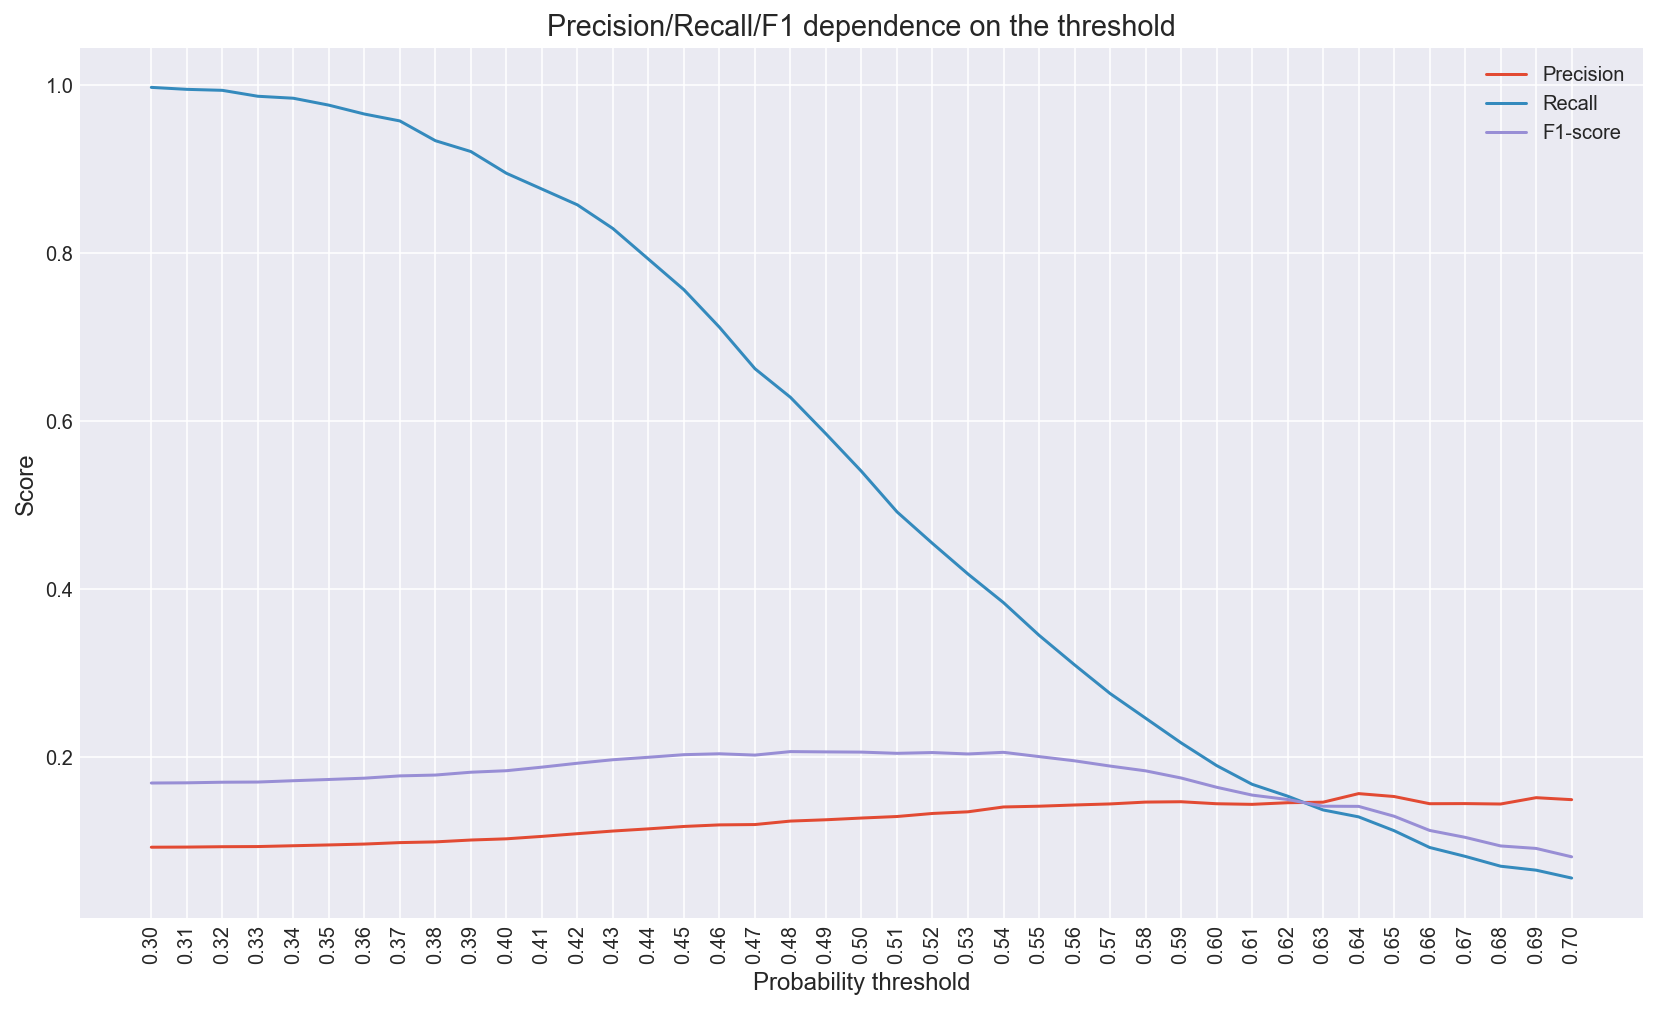

In [109]:
# Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(14, 8)) # фигура + координатная плоскость
# Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')
# Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')
# Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')

# Даем графику название и подписи осям
ax.set_title('Precision/Recall/F1 dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
# Устанавливаем отметки по оси x
ax.set_xticks(thresholds)
ax.tick_params(axis='x', labelrotation=90)
# Отображаем легенду
ax.legend();

Кривая выглядит значительно лучше чем на базовой моделе

Выбираю значение перед пересечением кривых, где Precision максимальный, а дальше снижается и Recall.

In [110]:
# Задаем оптимальный порог вероятностей для максимизации Precision
threshold_opt = 0.625

y_pred_opt = y_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
# Считаем метрики
print(classification_report(y_test, y_pred_opt))

              precision    recall  f1-score   support

         0.0       0.91      0.91      0.91      8428
         1.0       0.15      0.15      0.15       850

    accuracy                           0.84      9278
   macro avg       0.53      0.53      0.53      9278
weighted avg       0.84      0.84      0.84      9278



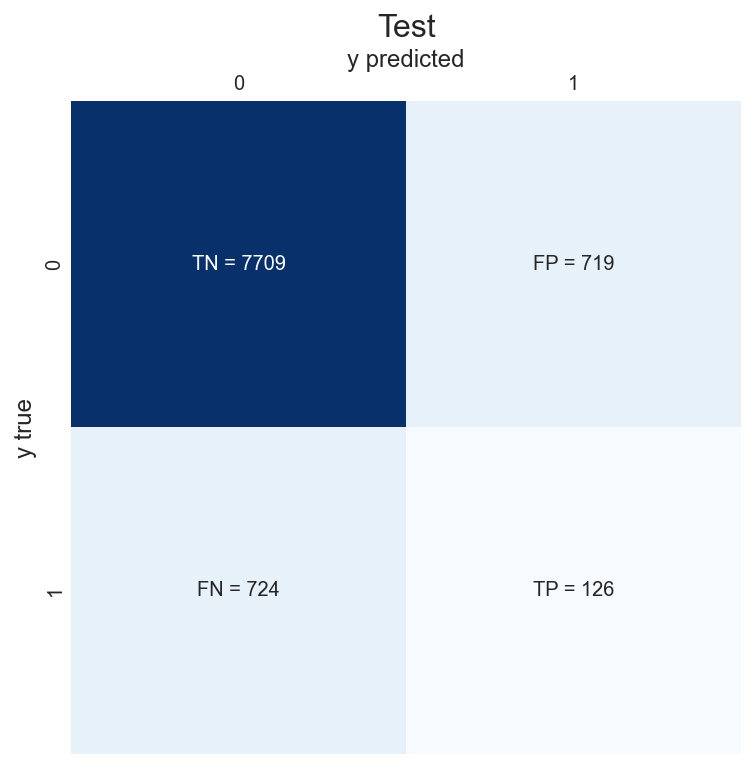

In [106]:
cm_test = confusion_matrix(y_test, y_pred_opt)
hd.plot_confusion_matrix(cm_test, 'Test')

# Случайный лес
подбор параметров вручную

In [154]:
rf = RandomForestClassifier(n_estimators=500, max_depth=5, min_samples_leaf=2, criterion='log_loss', class_weight='balanced')
rf.fit(X_train, y_train)

y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
hd.print_classification_metrics(y_train, y_train_pred, y_test, y_test_pred)

*** TRAIN ***
Accuracy: 0.580
Precision: 0.140
Recall: 0.695
F1: 0.233

*** TEST ***
Accuracy: 0.556
Precision: 0.125
Recall: 0.641
F1: 0.209


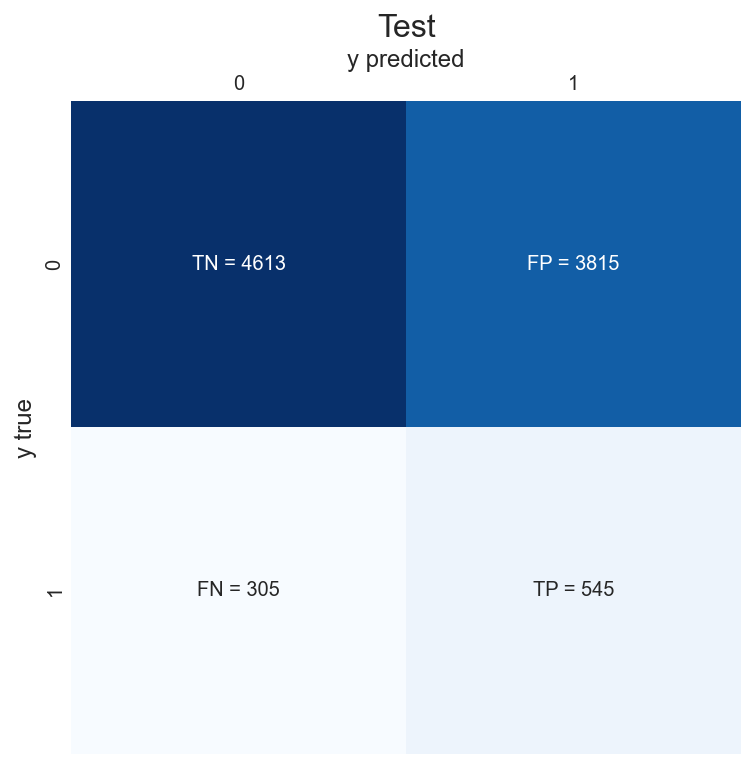

In [155]:
cm_test = confusion_matrix(y_test, y_test_pred)
hd.plot_confusion_matrix(cm_test, 'Test')

### Настройка порога вероятности для случайного леса

In [156]:
# Тут берем таблицу вероятностей и интересует только вероятность класса 1 (второй столбец)
y_proba_pred = rf.predict_proba(X_test)[:, 1]

# Для удобства завернем numpy-массив в pandas Series
y_proba_pred = pd.Series(y_proba_pred)

# Создадим списки, в которых будем хранить значения метрик
precision_scores = []
recall_scores = []
f1_scores = []

# Сгенерируем набор вероятностных порогов в диапазоне от 0.05 до 1
thresholds = np.arange(0.3, 0.7 + 0.01, 0.01)

# В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    # Пациентов, для которых вероятность наличия диабета > threshold относим к классу 1
    # В противном случае - к классу 0
    y_pred = y_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    
    # Считаем метрики и добавляем их в списки
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\avvoy\AppData\Local\Pr

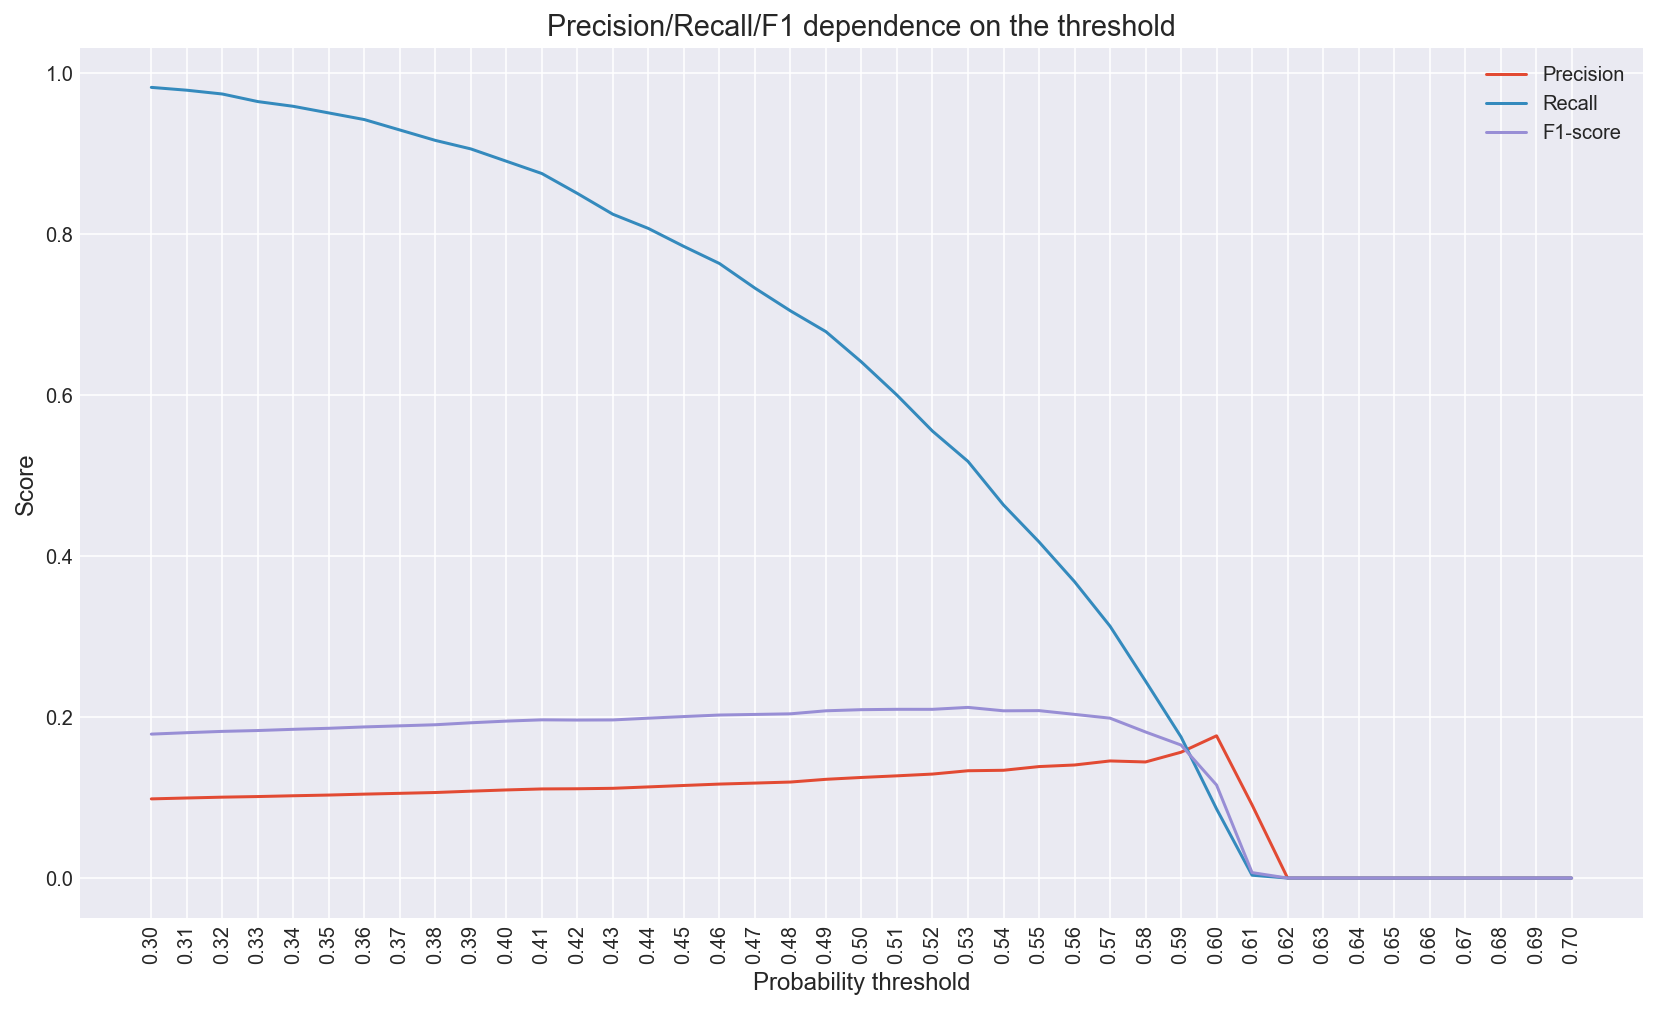

In [157]:
# Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(14, 8)) # фигура + координатная плоскость
# Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')
# Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')
# Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')

# Даем графику название и подписи осям
ax.set_title('Precision/Recall/F1 dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
# Устанавливаем отметки по оси x
ax.set_xticks(thresholds) 
ax.tick_params(axis='x', labelrotation=90)
# Отображаем легенду
ax.legend();

Логичным выглядит пересечение всех кривых

In [161]:
# Задаем оптимальный порог вероятностей для максимизации Precision
threshold_opt = 0.59

y_pred_opt = y_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
# Считаем метрики
print(classification_report(y_test, y_pred_opt))

              precision    recall  f1-score   support

         0.0       0.92      0.90      0.91      8428
         1.0       0.16      0.18      0.17       850

    accuracy                           0.84      9278
   macro avg       0.54      0.54      0.54      9278
weighted avg       0.85      0.84      0.84      9278



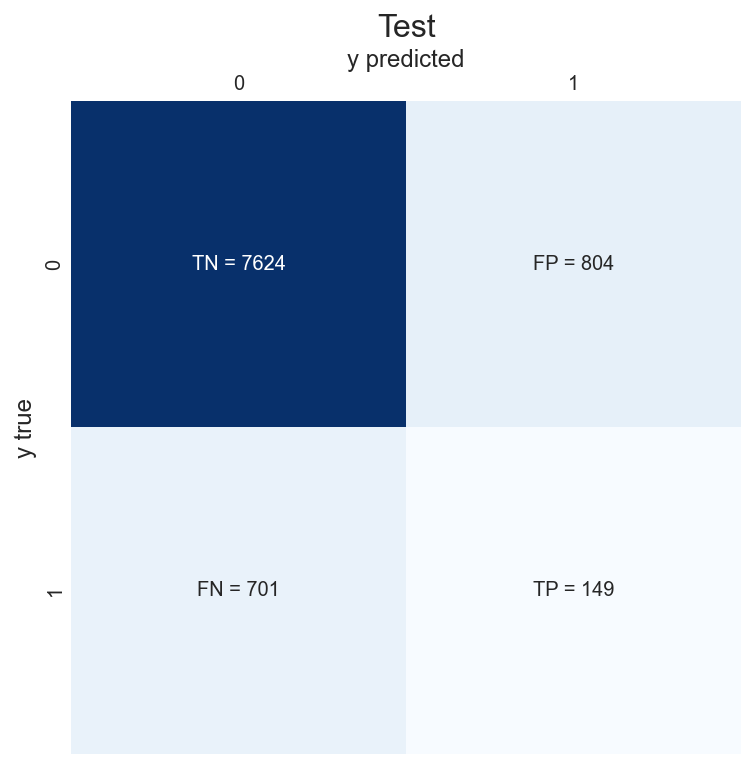

In [162]:
cm_test = confusion_matrix(y_test, y_pred_opt)
hd.plot_confusion_matrix(cm_test, 'Test')

Precision вырос до 16%, сделок стало сильно меньше.

In [163]:
X_test.shape

(9278, 151)

In [164]:
print(f'Сделка каждые {X_test.shape[0]//(cm_test[0, 1] + cm_test[1, 1])} часов')

Сделка каждые 9 часов


# GridSearch for RandomForest

In [167]:
param_grid = [
            # 'criterion': ['gini', 'entropy', 'log_loss'],
            # 'min_samples_leaf': list(range(1, 10, 1)),
            # 'max_depth': list(range(5, 35, 5)),
              {
                # 'n_estimators': list(range(50, 300, 50)),
                'max_features': ['sqrt', 'log2', None],
              },
]

grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(
                                     n_estimators=200,
                                     min_samples_leaf=2,
                                     max_depth=5,
                                     criterion='log_loss',
                                     class_weight='balanced'),
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    scoring=precision_score
)  

%time grid_search_rf.fit(X_train, y_train)
y_train_pred = grid_search_rf.predict(X_train)
y_test_pred = grid_search_rf.predict(X_test)

print(f'precision_score на train наборе: {precision_score(y_train, y_train_pred):.2f}')
print(f'recall_score на train наборе: {recall_score(y_train, y_train_pred):.2f}')
print(f'f1_score на train наборе: {f1_score(y_train, y_train_pred):.2f}')
print()
print(f'precision_score на test наборе: {precision_score(y_test, y_test_pred):.2f}')
print(f'recall_score на test наборе: {recall_score(y_test, y_test_pred):.2f}')
print(f'f1_score на test наборе: {f1_score(y_test, y_test_pred):.2f}')
print()
print(f'Наилучшие значения гиперпараметров: {grid_search_rf.best_params_}')

c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(


CPU times: total: 50.8 s
Wall time: 12min 27s
precision_score на train наборе: 0.14
recall_score на train наборе: 0.69
f1_score на train наборе: 0.23

precision_score на test наборе: 0.12
recall_score на test наборе: 0.64
f1_score на test наборе: 0.21

Наилучшие значения гиперпараметров: {'max_features': 'sqrt'}


In [153]:
# CPU times: total: 2min 5s
# Wall time: 3h 13min 39s
# precision_score на train наборе: 0.14
# recall_score на train наборе: 0.70
# f1_score на train наборе: 0.23

# precision_score на test наборе: 0.13
# recall_score на test наборе: 0.64
# f1_score на test наборе: 0.21

# Наилучшие значения гиперпараметров: {'max_depth': 5, 'min_samples_leaf': 2}

In [168]:
# Тут берем таблицу вероятностей и интересует только вероятность класса 1 (второй столбец)
y_proba_pred = grid_search_rf.predict_proba(X_test)[:, 1]

# Для удобства завернем numpy-массив в pandas Series
y_proba_pred = pd.Series(y_proba_pred)

# Создадим списки, в которых будем хранить значения метрик
precision_scores = []
recall_scores = []
f1_scores = []

# Сгенерируем набор вероятностных порогов в диапазоне от 0.05 до 1
thresholds = np.arange(0.3, 0.7 + 0.01, 0.01)

# В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    # Пациентов, для которых вероятность наличия диабета > threshold относим к классу 1
    # В противном случае - к классу 0
    y_pred = y_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    
    # Считаем метрики и добавляем их в списки
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\avvoy\AppData\Local\Pr

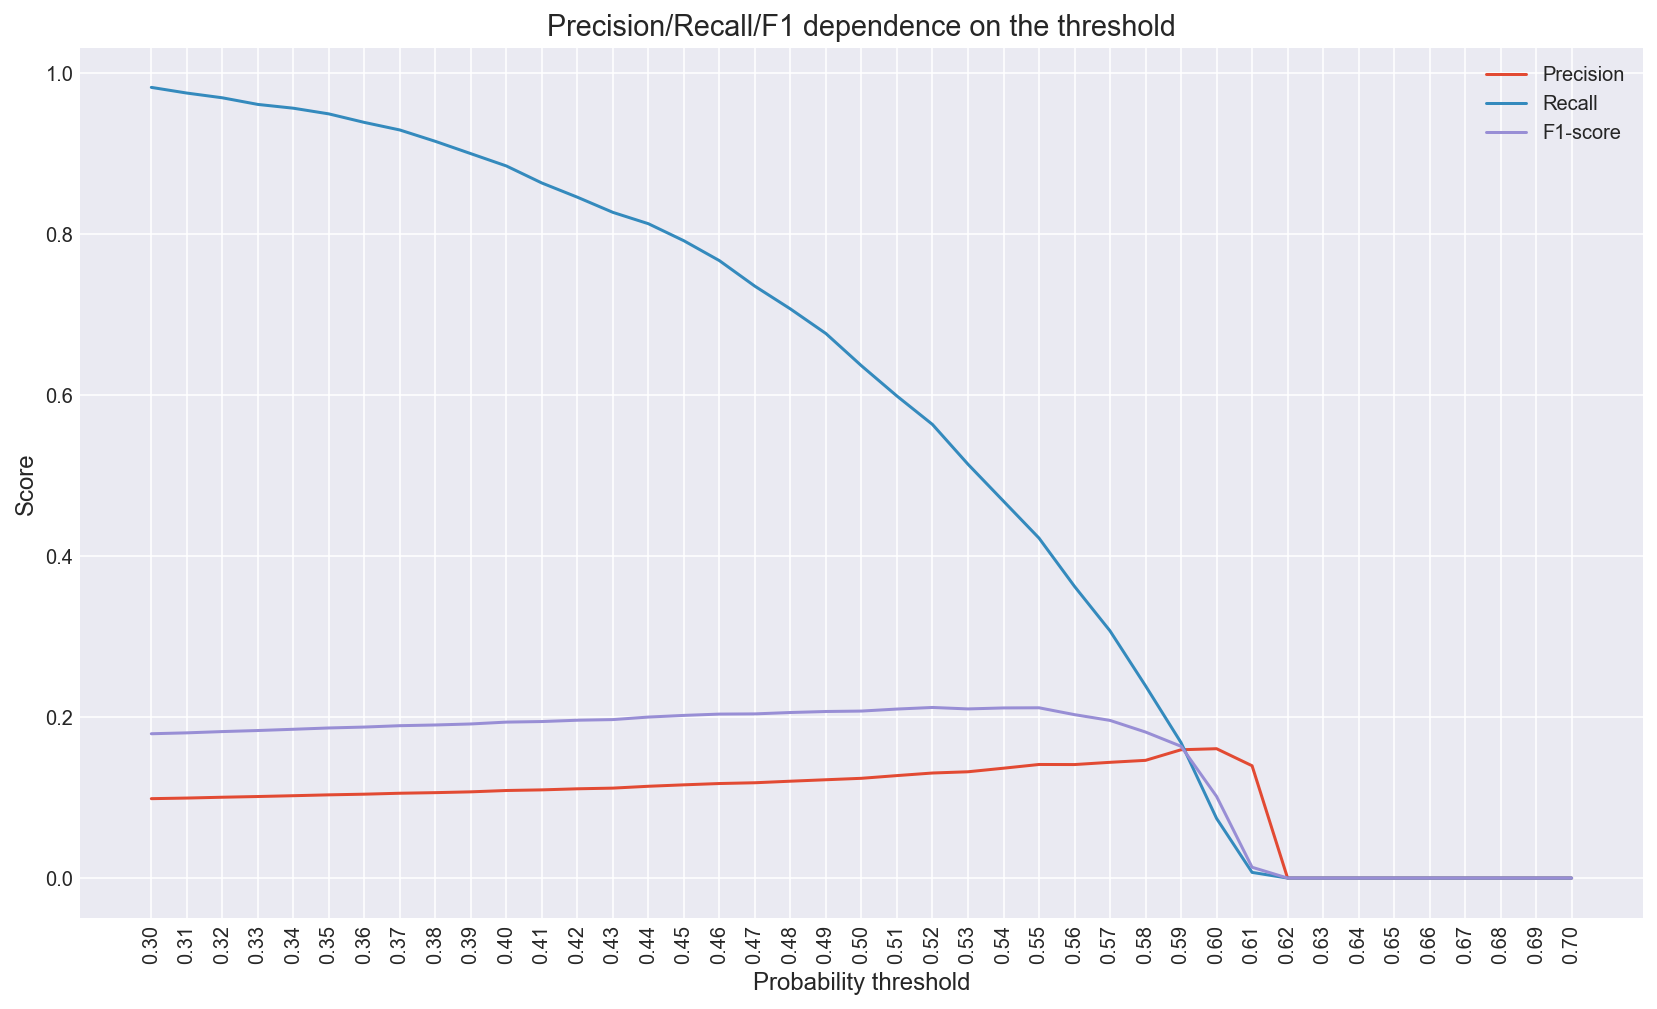

In [169]:
# Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(14, 8)) # фигура + координатная плоскость
# Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')
# Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')
# Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')

# Даем графику название и подписи осям
ax.set_title('Precision/Recall/F1 dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
# Устанавливаем отметки по оси x
ax.set_xticks(thresholds) 
ax.tick_params(axis='x', labelrotation=90)
# Отображаем легенду
ax.legend();

Логичным выглядит пересечение всех кривых

In [170]:
# Задаем оптимальный порог вероятностей для максимизации Precision
threshold_opt = 0.59

y_pred_opt = y_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
# Считаем метрики
print(classification_report(y_test, y_pred_opt))

              precision    recall  f1-score   support

         0.0       0.92      0.91      0.91      8428
         1.0       0.16      0.17      0.16       850

    accuracy                           0.84      9278
   macro avg       0.54      0.54      0.54      9278
weighted avg       0.85      0.84      0.84      9278



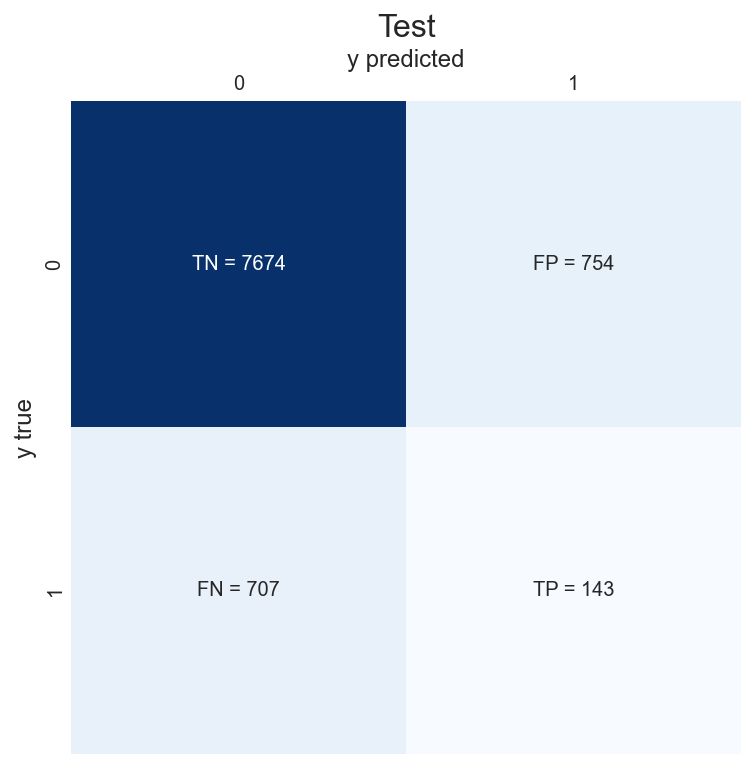

In [171]:
cm_test = confusion_matrix(y_test, y_pred_opt)
hd.plot_confusion_matrix(cm_test, 'Test')

# RandomSearch for RandomForest

In [125]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

In [126]:
param_distributions = {'n_estimators': list(range(200, 550, 50)),
              'min_samples_leaf': list(range(3, 15, 2)),
              'max_depth': list(range(5, 35, 5)),
            #   'criterion': ['gini', 'entropy', 'log_loss']
              }
            
random_search_forest = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1),
    param_distributions=param_distributions,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_iter=5,
    n_jobs=-1,
    scoring=f1_score
)

%time random_search_forest.fit(X_train, y_train)
y_train_pred = random_search_forest.predict(X_train)
y_test_pred = random_search_forest.predict(X_test)

print(f'precision_score на train наборе: {precision_score(y_train, y_train_pred):.2f}')
print(f'recall_score на train наборе: {recall_score(y_train, y_train_pred):.2f}')
print(f'f1_score на train наборе: {f1_score(y_train, y_train_pred):.2f}')
print()
print(f'precision_score на test наборе: {precision_score(y_test, y_test_pred):.2f}')
print(f'recall_score на test наборе: {recall_score(y_test, y_test_pred):.2f}')
print(f'f1_score на test наборе: {f1_score(y_test, y_test_pred):.2f}')
print()
print(f'Наилучшие значения гиперпараметров: {random_search_forest.best_params_}')

c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  warnings.warn(


CPU times: total: 2min 56s
Wall time: 8min 9s
precision_score на train наборе: 0.99
recall_score на train наборе: 0.99
f1_score на train наборе: 0.99

precision_score на test наборе: 0.08
recall_score на test наборе: 0.00
f1_score на test наборе: 0.01

Наилучшие значения гиперпараметров: {'n_estimators': 250, 'min_samples_leaf': 9, 'max_depth': 20}


In [128]:
random_search_forest.best_estimator_

RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_leaf=9, n_estimators=250, n_jobs=-1,
                       random_state=42)

### Настройка порога вероятности для RandomSearch for RandomForest

In [129]:
# Тут берем таблицу вероятностей и интересует только вероятность класса 1 (второй столбец)
y_proba_pred = random_search_forest.predict_proba(X_test)[:, 1]

# Для удобства завернем numpy-массив в pandas Series
y_proba_pred = pd.Series(y_proba_pred)

# Создадим списки, в которых будем хранить значения метрик
precision_scores = []
recall_scores = []
f1_scores = []

# Сгенерируем набор вероятностных порогов в диапазоне от 0.05 до 1
thresholds = np.arange(0.3, 0.7 + 0.01, 0.01)

# В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    # Пациентов, для которых вероятность наличия диабета > threshold относим к классу 1
    # В противном случае - к классу 0
    y_pred = y_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    
    # Считаем метрики и добавляем их в списки
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\avvoy\AppData\Local\Pr

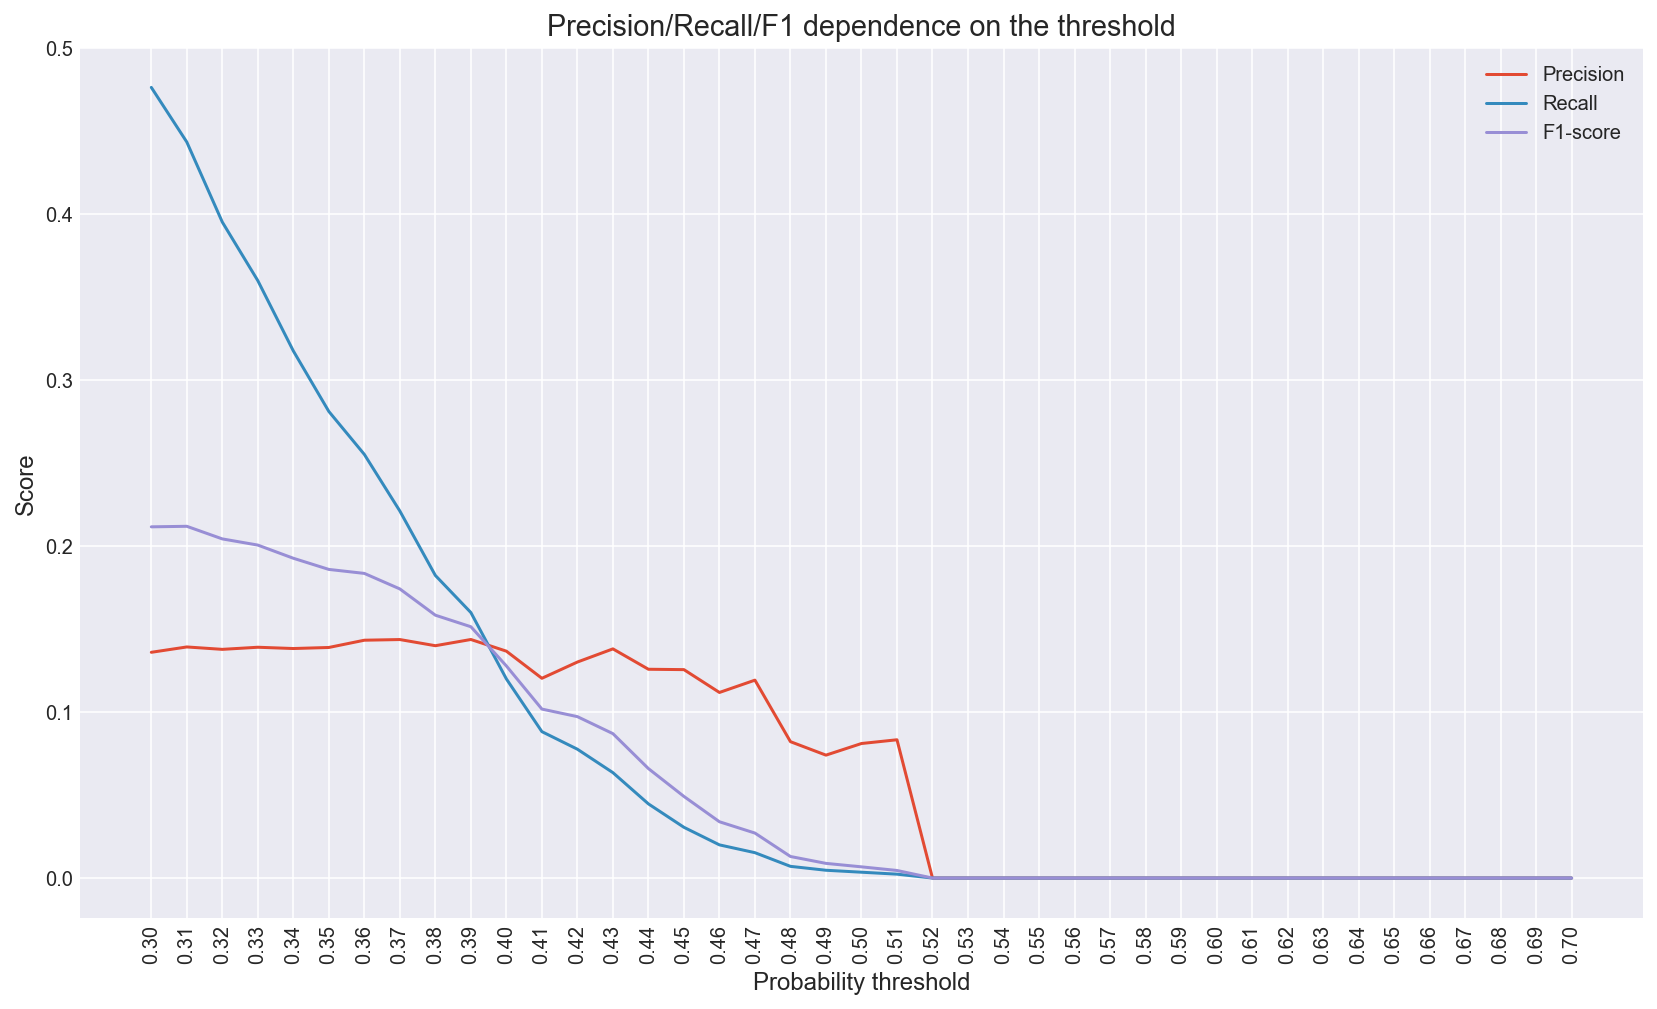

In [130]:
# Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(14, 8)) # фигура + координатная плоскость
# Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')
# Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')
# Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')

# Даем графику название и подписи осям
ax.set_title('Precision/Recall/F1 dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
# Устанавливаем отметки по оси x
ax.set_xticks(thresholds) 
ax.tick_params(axis='x', labelrotation=90)
# Отображаем легенду
ax.legend();

Логичным выглядит пересечение всех кривых

In [ ]:
# Задаем оптимальный порог вероятностей для максимизации Precision
threshold_opt = 0.59

y_pred_opt = y_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
# Считаем метрики
print(classification_report(y_test, y_pred_opt))

              precision    recall  f1-score   support

         0.0       0.92      0.91      0.91      8428
         1.0       0.16      0.16      0.16       850

    accuracy                           0.84      9278
   macro avg       0.54      0.54      0.54      9278
weighted avg       0.85      0.84      0.84      9278



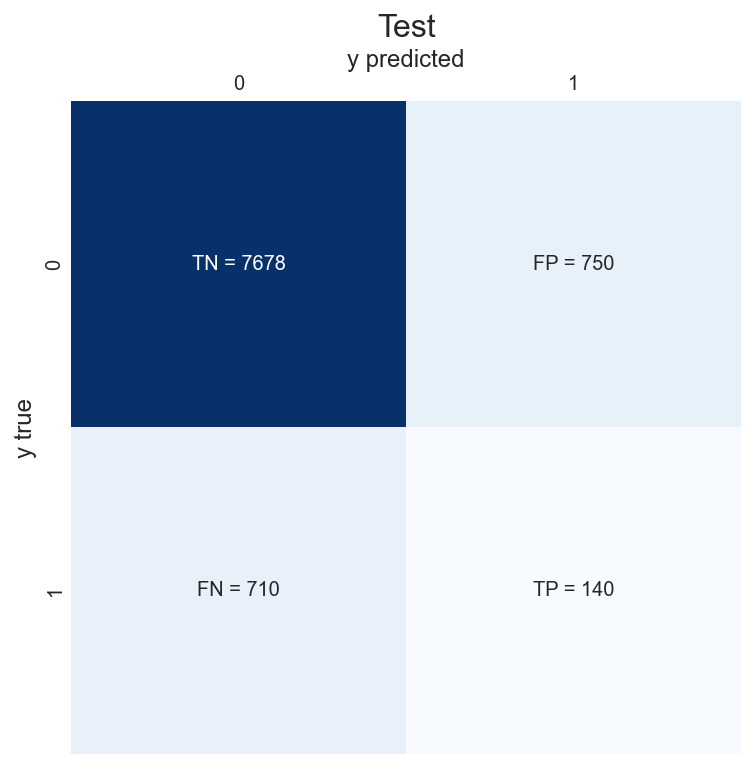

In [ ]:
cm_test = confusion_matrix(y_test, y_pred_opt)
hd.plot_confusion_matrix(cm_test, 'Test')

Precision вырос до 16%, сделок стало сильно меньше.

In [ ]:
X_test.shape

(9278, 151)

In [ ]:
print(f'Сделка каждые {X_test.shape[0]//(cm_test[0, 1] + cm_test[1, 1])} часов')

Сделка каждые 10 часов
